# Similarity Attention (SimAtt)

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from utils import *
from explanations import SimAtt

cudnn.benchmark = True

In [2]:
args = Dummy()

# Number of workers to load data
args.workers = 8
# Directory with images split into class folders.
# Since we don't use ground truth labels for saliency all images can be 
# moved to one class folder.
args.datadir = '/home/brian/data/leedsbutterfly/'
# Sets the range of images to be explained for dataloader.
args.range = range(95, 105)
# Size of imput images.
args.input_size = (224, 224)
# Size of batches for GPU. 
# Use maximum number that the GPU allows.
args.gpu_batch = 250

## Prepare data

In [3]:
dataset = datasets.ImageFolder(args.datadir, preprocess)

# This example only works with batch size 1. For larger batches see RISEBatch in explanations.py.
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False,
    num_workers=args.workers, pin_memory=True, sampler=RangeSampler(args.range))

print('Found {: >5} images belonging to {} classes.'.format(len(dataset), len(dataset.classes)))
print('      {: >5} images will be explained.'.format(len(data_loader) * data_loader.batch_size))

Found   832 images belonging to 2 classes.
         10 images will be explained.


## Load black-box model

In [4]:
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(*list(model.children())[:-1], nn.Flatten())
model = model.eval()
model = model.cuda()
    
# To use multiple GPUs
# model = nn.DataParallel(model)

## Create explainer instance

In [5]:
explainer = SimAtt(model, feature_module=model[7], target_layer_names=["2"], input_size=args.input_size)

## Explaining one instance

In [6]:
def example(query_img, img):
    s = explainer(query_img.cuda(), img.cuda()).cpu().numpy()
    print(s.shape)
    plt.figure(figsize=(10, 15))
    
    plt.subplot(1, 4, 1)
    plt.axis('off')
    tensor_imshow(query_img[0])
    
    plt.subplot(1, 4, 2)
    plt.axis('off')
    tensor_imshow(img[0])
    
    plt.subplot(1, 4, 3)
    plt.axis('off')
    tensor_imshow(query_img[0])
    plt.imshow(s[0], cmap='jet', alpha=0.5)
    plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(1, 4, 4)
    plt.axis('off')
    tensor_imshow(img[0])
    plt.imshow(s[1], cmap='jet', alpha=0.5)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.show()

/home/brian/miniconda3/envs/drilldown/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(2, 224, 224)


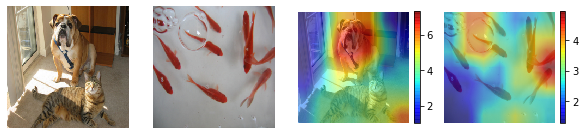

In [7]:
example(read_tensor('catdog.png'), read_tensor('goldfish.jpg'))

## Explaining all images in dataloader

In [8]:
def explain_all(data_loader, explainer):
    # Get saliency maps for all images in val loader
    explanations = np.empty((len(data_loader), 2, *args.input_size))
    for i, (img, _) in enumerate(tqdm(data_loader, total=len(data_loader), desc='Explaining images')):
        if i == 0:
            # Save base image
            base_img = img
        saliency_maps = explainer(base_img.cuda(), img.cuda())
        explanations[i] = saliency_maps.cpu().numpy()
    return explanations

In [9]:
explanations = explain_all(data_loader, explainer)

# Save explanations if needed.
# explanations.tofile('exp_{:05}-{:05}.npy'.format(args.range[0], args.range[-1]))

Explaining images: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


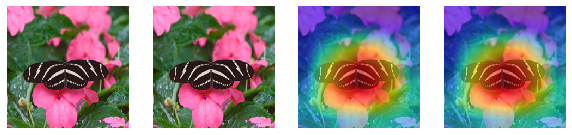

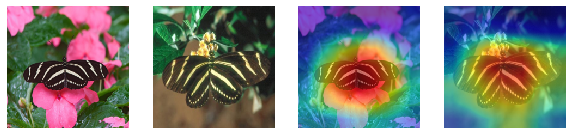

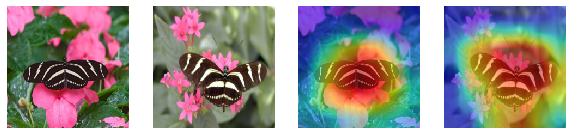

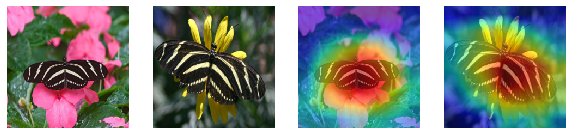

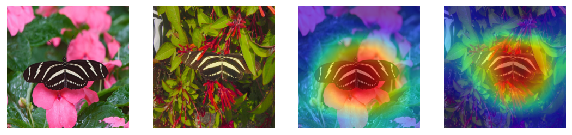

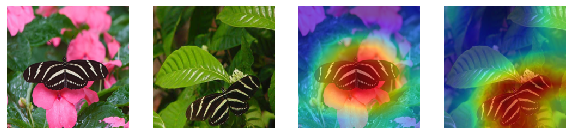

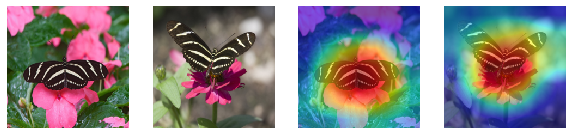

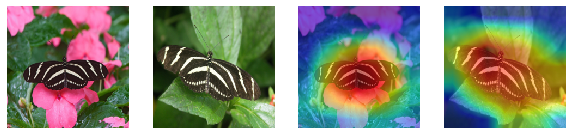

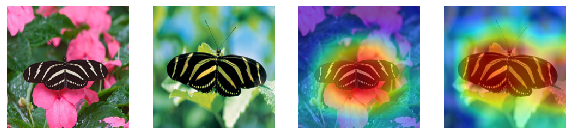

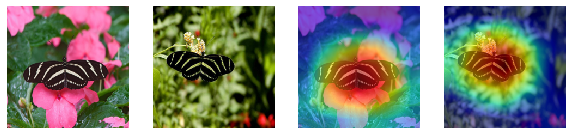

In [10]:
for i, (img, _) in enumerate(data_loader):
    if i == 0:
        base_img = img
    plt.figure(figsize=(10, 5))
    plt.subplot(141)
    plt.axis('off')
    tensor_imshow(base_img[0])
    
    plt.subplot(142)
    plt.axis('off')
    tensor_imshow(img[0])
    
    plt.subplot(143)
    plt.axis('off')
    tensor_imshow(base_img[0])
    sal = explanations[i,0]
    plt.imshow(sal, cmap='jet', alpha=0.5)
    
    plt.subplot(144)
    plt.axis('off')
    tensor_imshow(img[0])
    sal = explanations[i,1]
    plt.imshow(sal, cmap='jet', alpha=0.5)
    
    plt.show()